<div dir="rtl">

# استخراج النصوص من الوثائق المصوّرة

</div>

In [1]:
import boto3

In [2]:
bedrock_runtime = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock = boto3.client("bedrock", region_name="us-west-2")

In [3]:
!sudo apt install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [4]:
!mkdir -p ../documents
!mkdir -p ../output/raw
!mkdir -p ../output/cleaned
!mkdir -p ../output/images

In [5]:
!wget -O ../documents/aws-cloud-adoption-framework.pdf -nc https://d1.awsstatic.com/whitepapers/International/ar/aws-cloud-adoption-framework.pdf --no-check-certificate

File ‘../documents/aws-cloud-adoption-framework.pdf’ already there; not retrieving.


In [6]:
document = "../documents/aws-cloud-adoption-framework.pdf"

In [7]:
ls -alh {document}

-rw-r--r-- 1 sagemaker-user users 1.3M Mar  9  2022 ../documents/aws-cloud-adoption-framework.pdf


In [8]:
!pdfinfo {document}

Title:           إطار عمل اعتماد السحابة من AWS
Subject:         إطار عمل اعتماد السحابة من AWS
Keywords:        CAF, Adoption
Author:          Amazon Web Services
Creator:         Microsoft Word
CreationDate:    Fri Mar  4 21:17:33 2022 UTC
ModDate:         Fri Mar  4 21:35:12 2022 UTC
Custom Metadata: no
Metadata Stream: yes
Tagged:          yes
UserProperties:  no
Suspects:        no
Form:            none
JavaScript:      no
Pages:           25
Encrypted:       no
Page size:       612 x 792 pts (letter)
Page rot:        0
File size:       1336106 bytes
Optimized:       no
PDF version:     1.7


In [9]:
filename = document.split("/")[-1].split(".")[0]
filename

'aws-cloud-adoption-framework'

<div dir="rtl">

نقوم باستخراج صفحة مُعيّنة في شكل صورة من مُستند ال PDF
لنستعملها في تمرين استخراج النصوص من الوثائق المُصوّرة

</div>

In [10]:
page_number = 6

In [11]:
!pdftoppm -png -f {page_number} -l {page_number} {document} ../output/images/{filename}-pg


In [12]:
page_number = str(page_number).zfill(2)
image_path = f"../output/images/{filename}-pg-{page_number}.png"

In [28]:
!mediainfo {image_path}

/bin/bash: line 1: mediainfo: command not found


Width: 1275, Height: 1651


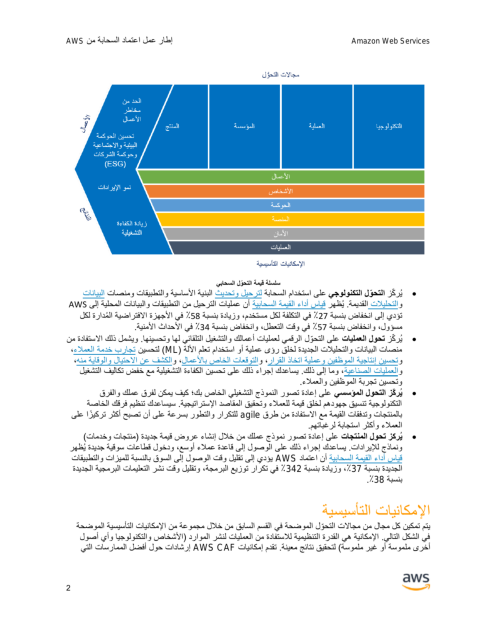

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
img = Image.open(image_path)
width, height = img.size
print(f"Width: {width}, Height: {height}")
# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

<div dir="rtl">

## استخراج النصوص باستخدام نموذج لغوي كبير

</div>

<div dir="rtl">

نبدأ أوّلا بتحميل صورة الصفحة التي تحتوى على النصّ الذي نريد استخراجه، ثم تحويل المُحتوى إلى تنسيق base64

</div>

In [15]:
import base64


def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    base64_image = base64.b64encode(image_data)
    base64_string = base64_image.decode("utf-8")

    return base64_string

In [16]:
page_base64 = image_to_base64(image_path)

In [23]:
english_prompt = """
This image is a page from a document in arabic, review it carrefully and transcribe the text accurately in its original language.
Write the output as markdown and put it inside an xml tag called <markdown>"
"""

In [ ]:
arabic_prompt = """
هذه الصورة هي صفحة من مستند باللغة العربية، راجعها بعناية وانسخ النص بدقة في لغته الأصلية.
اكتب الناتج بصيغة Markdown وضعه داخل وسم XML يسمى <markdown>
"""

In [18]:
import json


use_arabic_prompt = False

if use_arabic_prompt:
    prompt = arabic_prompt
else:
    prompt = english_prompt

# https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html
body = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature": 0.0,
    "top_k":250,
    "top_p":0.99,
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": page_base64
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]
})

In [19]:
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = 'application/json'
contentType = 'application/json'

response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

In [20]:
import bs4


def extract_tag(xml_text, tag='markdown'):
    soup = bs4.BeautifulSoup(xml_text, 'html.parser')
    summary_tag = soup.find(tag)
    if summary_tag:
        return summary_tag.text.strip()
    else:
        return None

In [21]:
text = response_body["content"][0]["text"]

print(extract_tag(text, tag='markdown'))

AWS من AWS إطار عمل اعتماد السحابة

Amazon Web Services

مجالات العوان

الأمن
الدين من
خدمات
(الأمان)

الشبكة

المؤسسة

الهوية

التكرارية

تأمين الهوية
الشبكة الاجتماعية
وحدة كل شركات
(ESG)

نمو الأولويات

رؤية الخدمة
المتقدمة

الأساس
الأدوات
الشركة

الأمن
العمليات

الاتصالات الأساسية

سلسلة قيمة التحول السحابي

• يركز التحول الكبيرولوجي على استخدام السحابة لنقل وتحديث البنية الأساسية والتطبيقات ومصادر البيانات.
والتحديات البيئية، تظهر كل يوم. إذا البنية السحابية أن عمليات التوصيل من التطبيقات والبيانات السحابية إلى AWS
تتطلب تغييرًا كبيرًا في ثقافة الشركة. لقد تم تصميم 7/38 نسبة 7/37 من الشركات لديها برامج تحول رسمية، و 7/57
نسبة 7/34 من المؤسسات الأعمال في الأعمال الأعمال، وتطبيق وقت التشغيل.

• يركز التحول المؤسسي على التحول الرقمي لعملياته وإدارته والتشغيل التلقائي لها وتحسينها. وسيشمل ذلك الاستفادة من
مصممات البيانات والحوسبات الجديدة لخلق رؤى عملية أو استخدام نظام الآلة (ML) لتحسين تجارب خدمة العملاء.
وتحسين الكفاءة مع تطوير القدرات الجديدة، والكشف عن الاحتيال، والتأكيد.

• والعم

In [24]:
response_body.keys()

dict_keys(['id', 'type', 'role', 'model', 'content', 'stop_reason', 'stop_sequence', 'usage'])

<div dir="rtl">

### تقدير كُلفة استخراج الصفحة

</div>

In [25]:
response_body["usage"]

{'input_tokens': 1583, 'output_tokens': 1389}

In [27]:
# Claude 3 Sonnet pricing on Bedrock based on https://aws.amazon.com/bedrock/pricing/
price_per_input_token = 0.003 / 1000
price_per_output_token = 0.015 / 1000

response_body["usage"]["input_tokens"] * price_per_input_token + response_body["usage"]["output_tokens"] * price_per_output_token

0.025584